Обзор данных
Описание датасета

Home Ownership - домовладение  

Annual Income - годовой доход  

Years in current job - количество лет на текущем месте работы  

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from typing import List, Optional
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import statsmodels.api as sm
from tqdm import tqdm
import lightgbm as lgb
import catboost as cb
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
import sklearn as sk
from sklearn.metrics import roc_auc_score, f1_score,r2_score,classification_report,accuracy_score,precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [3]:
def enc_target(train,feature,target):
    d = train[train[target]==1].groupby(feature).size()/len(train)*100
    return d



In [4]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,print_is = True):
   
    
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train) 

        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if print_is:
            print(msg)
            print("="*69)
        estimators.append(estimator)
    oof_score = metric(y, oof_predictions)
    if print_is:
        print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
        print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
        print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions   

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
train = pd.read_csv("train.csv")

In [7]:
target = 'Credit Default'

In [8]:
X_train,X_test,y_train,y_test = train_test_split(train,train[target],test_size = 0.15,random_state = 10)

In [9]:
X_test.to_csv('test.csv',index=False)
y_test.to_csv('y_test.csv',index=False)

Изменения  в данных

время раьботы на последнем месте сделаем дискретным признаком

In [10]:
d={}
for i in train['Years in current job'].value_counts().index:
    if i[:2]=='10':
        d[i]=10
        continue
    if i[0]=='<':
        d[i]=0
        continue    
X_train['Years in current job'] = train['Years in current job'].map(d)    

уберем немножко выбросов

In [11]:
X_train.loc[train['Maximum Open Credit']>7000000,'Maximum Open Credit']=7000000

заменим пропуски на 999

In [12]:
X_train.fillna(999,inplace=True)

разделим признаки по катеогриям

In [13]:
target_col = ['Credit Default']
categorical_features=['Home Ownership','Tax Liens','Purpose','Term']
discrete_feature = ['Years in current job','Number of Open Accounts',\
                    'Years of Credit History','Number of Credit Problems',\
                   'Months since last delinquent','Bankruptcies','Credit Score']
continuous_feature = ['Annual Income','Maximum Open Credit','Current Loan Amount',\
                      'Current Credit Balance','Monthly Debt']
len(target_col + categorical_features +  discrete_feature + continuous_feature)

17

Категориальные признаки закодирем по таргету

In [14]:
for i in categorical_features:
    d = enc_target(X_train,i,target)
    X_train[i] = X_train[i].map(d)
    X_train[i] = X_train[[i]].fillna(0)

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6375 entries, 2048 to 1289
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                6375 non-null   float64
 1   Annual Income                 6375 non-null   float64
 2   Years in current job          6375 non-null   float64
 3   Tax Liens                     6375 non-null   float64
 4   Number of Open Accounts       6375 non-null   float64
 5   Years of Credit History       6375 non-null   float64
 6   Maximum Open Credit           6375 non-null   float64
 7   Number of Credit Problems     6375 non-null   float64
 8   Months since last delinquent  6375 non-null   float64
 9   Bankruptcies                  6375 non-null   float64
 10  Purpose                       6375 non-null   float64
 11  Term                          6375 non-null   float64
 12  Current Loan Amount           6375 non-null   float64
 13  

Подготовка данных для линеной регрессии

In [16]:
data_lr  = X_train.copy()
X_train_lr = data_lr.drop('Credit Default',1)


In [17]:
for i in categorical_features:
    X_train_lr=pd.concat([X_train_lr,pd.get_dummies(X_train_lr[i],prefix=i)],axis=1)
    X_train_lr.drop(i,1,inplace=True)


In [18]:
for i in continuous_feature + discrete_feature:
    X_train_lr[i]=StandardScaler().fit_transform(X_train_lr[[i]])
    X_train_lr[i]=StandardScaler().fit_transform(X_train_lr[[i]])

In [19]:
new = pd.DataFrame()
num_columns = X_train_lr.columns.to_list()[:12]
for col1 in num_columns:  
    new[col1+'_**2'] = (X_train_lr[i])**2
    new[col1+'_**3'] = (X_train_lr[i])**3
    new[col1+'_log'] = np.log(X_train_lr[col1] +2.2)
    
    for col2 in num_columns:
        new[col1+'_'+col2+'_*'] = X_train_lr[col1] *X_train_lr[col2]
        if col1!=col2 :
            new[col1+'_'+col2+'_/'] =X_train_lr[col1] /X_train_lr[col2]


In [20]:
good_list = ['Annual Income_**2',
 'Years in current job_**2',
 'Number of Open Accounts_**2',
 'Years of Credit History_**2',
 'Maximum Open Credit_**2',
 'Number of Credit Problems_**2',
 'Months since last delinquent_**2',
 'Bankruptcies_**2',
 'Current Loan Amount_**2',
 'Current Credit Balance_**2',
 'Monthly Debt_**2',
 'Credit Score_**2',
 'Credit Score_Credit Score_*',
 'Annual Income_**3',
 'Years in current job_**3',
 'Number of Open Accounts_**3',
 'Years of Credit History_**3',
 'Maximum Open Credit_**3',
 'Number of Credit Problems_**3',
 'Months since last delinquent_**3',
 'Bankruptcies_**3',
 'Current Loan Amount_**3',
 'Current Credit Balance_**3',
 'Monthly Debt_**3',
 'Credit Score_**3',
 'Annual Income_Credit Score_/',
 'Annual Income_Months since last delinquent_*',
 'Months since last delinquent_Annual Income_*',
 'Annual Income_Months since last delinquent_/',
 'Current Loan Amount_Credit Score_/',
 'Number of Open Accounts_Maximum Open Credit_*',
 'Maximum Open Credit_Number of Open Accounts_*',
 'Credit Score_Number of Open Accounts_/',
 'Number of Open Accounts_Current Credit Balance_*',
 'Current Credit Balance_Number of Open Accounts_*',
 'Months since last delinquent_Current Credit Balance_*',
 'Current Credit Balance_Months since last delinquent_*',
 'Bankruptcies_Years of Credit History_/',
 'Current Credit Balance_Months since last delinquent_/',
 'Annual Income_Credit Score_*',
 'Credit Score_Annual Income_*',
 'Number of Credit Problems_Credit Score_/',
 'Maximum Open Credit_log',
 'Current Loan Amount_Number of Credit Problems_/',
 'Years of Credit History_Current Credit Balance_/',
 'Annual Income_Number of Open Accounts_/',
 'Monthly Debt_Bankruptcies_/',
 'Maximum Open Credit_Years of Credit History_/',
 'Monthly Debt_Number of Credit Problems_/',
 'Current Credit Balance_Years of Credit History_/',
 'Years of Credit History_log',
 'Years of Credit History_Years of Credit History_*',
 'Months since last delinquent_Credit Score_/',
 'Number of Open Accounts_Number of Credit Problems_*',
 'Number of Credit Problems_Number of Open Accounts_*',
 'Number of Open Accounts_Years in current job_/',
 'Annual Income_Monthly Debt_*',
 'Monthly Debt_Annual Income_*',
 'Annual Income_Years of Credit History_*',
 'Years of Credit History_Annual Income_*',
 'Current Credit Balance_Maximum Open Credit_/',
 'Current Loan Amount_Current Loan Amount_*',
 'Months since last delinquent_Monthly Debt_*',
 'Monthly Debt_Months since last delinquent_*',
 'Maximum Open Credit_Number of Credit Problems_*',
 'Number of Credit Problems_Maximum Open Credit_*',
 'Monthly Debt_Months since last delinquent_/',
 'Number of Open Accounts_Monthly Debt_/',
 'Number of Credit Problems_Number of Open Accounts_/',
 'Maximum Open Credit_Bankruptcies_*',
 'Bankruptcies_Maximum Open Credit_*',
 'Credit Score_Monthly Debt_/',
 'Maximum Open Credit_Current Loan Amount_/',
 'Years of Credit History_Number of Credit Problems_/',
 'Monthly Debt_Credit Score_/',
 'Number of Credit Problems_Monthly Debt_*',
 'Monthly Debt_Number of Credit Problems_*',
 'Annual Income_Years in current job_*',
 'Years in current job_Annual Income_*',
 'Current Loan Amount_Number of Open Accounts_/',
 'Number of Open Accounts_Bankruptcies_*',
 'Bankruptcies_Number of Open Accounts_*',
 'Number of Credit Problems_Current Credit Balance_*',
 'Current Credit Balance_Number of Credit Problems_*',
 'Annual Income_Maximum Open Credit_*',
 'Maximum Open Credit_Annual Income_*',
 'Annual Income_log',
 'Credit Score_Maximum Open Credit_/',
 'Bankruptcies_Number of Open Accounts_/',
 'Months since last delinquent_Credit Score_*',
 'Credit Score_Months since last delinquent_*',
 'Maximum Open Credit_Months since last delinquent_*',
 'Months since last delinquent_Maximum Open Credit_*',
 'Months since last delinquent_Annual Income_/',
 'Maximum Open Credit_Maximum Open Credit_*',
 'Number of Open Accounts_Number of Credit Problems_/',
 'Number of Credit Problems_Current Credit Balance_/',
 'Current Credit Balance_Credit Score_/',
 'Number of Open Accounts_Current Loan Amount_/',
 'Credit Score_Months since last delinquent_/',
 'Current Loan Amount_Months since last delinquent_/',
 'Maximum Open Credit_Months since last delinquent_/',
 'Maximum Open Credit_Bankruptcies_/',
 'Maximum Open Credit_Credit Score_*',
 'Credit Score_Maximum Open Credit_*',
 'Maximum Open Credit_Current Loan Amount_*',
 'Current Loan Amount_Maximum Open Credit_*',
 'Number of Credit Problems_Credit Score_*',
 'Credit Score_Number of Credit Problems_*',
 'Years in current job_Monthly Debt_/',
 'Months since last delinquent_Months since last delinquent_*',
 'Years in current job_Number of Open Accounts_*',
 'Number of Open Accounts_Years in current job_*',
 'Number of Credit Problems_log',
 'Years in current job_Current Loan Amount_*',
 'Current Loan Amount_Years in current job_*',
 'Monthly Debt_Current Loan Amount_/',
 'Bankruptcies_Current Credit Balance_*',
 'Current Credit Balance_Bankruptcies_*',
 'Years in current job_Current Loan Amount_/',
 'Bankruptcies_Number of Credit Problems_/',
 'Bankruptcies_Bankruptcies_*',
 'Years in current job_Years in current job_*',
 'Years in current job_log',
 'Annual Income_Current Loan Amount_*',
 'Current Loan Amount_Annual Income_*',
 'Years in current job_Bankruptcies_*',
 'Bankruptcies_Years in current job_*',
 'Years in current job_Credit Score_*',
 'Credit Score_Years in current job_*',
 'Months since last delinquent_Current Loan Amount_*',
 'Current Loan Amount_Months since last delinquent_*',
 'Bankruptcies_log',
 'Bankruptcies_Current Loan Amount_*',
 'Current Loan Amount_Bankruptcies_*',
 'Months since last delinquent_Current Loan Amount_/',
 'Years of Credit History_Current Loan Amount_*',
 'Current Loan Amount_Years of Credit History_*',
 'Current Loan Amount_Monthly Debt_*',
 'Monthly Debt_Current Loan Amount_*',
 'Bankruptcies_Months since last delinquent_/',
 'Current Loan Amount_Current Credit Balance_*',
 'Current Credit Balance_Current Loan Amount_*',
 'Number of Credit Problems_Current Loan Amount_*',
 'Current Loan Amount_Number of Credit Problems_*',
 'Current Credit Balance_Credit Score_*',
 'Credit Score_Current Credit Balance_*',
 'Years of Credit History_Credit Score_*',
 'Credit Score_Years of Credit History_*',
 'Bankruptcies_Years in current job_/',
 'Monthly Debt_Credit Score_*',
 'Credit Score_Monthly Debt_*',
 'Number of Open Accounts_Current Loan Amount_*',
 'Current Loan Amount_Number of Open Accounts_*',
 'Months since last delinquent_log',
 'Months since last delinquent_Number of Open Accounts_/',
 'Bankruptcies_Current Loan Amount_/',
 'Number of Credit Problems_Bankruptcies_*',
 'Bankruptcies_Number of Credit Problems_*',
 'Months since last delinquent_Bankruptcies_*',
 'Bankruptcies_Months since last delinquent_*',
 'Years of Credit History_Current Loan Amount_/',
 'Current Loan Amount_log',
 'Number of Credit Problems_Current Loan Amount_/',
 'Annual Income_Current Loan Amount_/',
 'Bankruptcies_Monthly Debt_*',
 'Monthly Debt_Bankruptcies_*',
 'Number of Open Accounts_Credit Score_*',
 'Credit Score_Number of Open Accounts_*',
 'Current Loan Amount_Credit Score_*',
 'Credit Score_Current Loan Amount_*',
 'Bankruptcies_Credit Score_*',
 'Credit Score_Bankruptcies_*',
 'Years in current job_Current Credit Balance_/',
 'Bankruptcies_Current Credit Balance_/',
 'Bankruptcies_Credit Score_/',
 'Years of Credit History_Bankruptcies_*',
 'Bankruptcies_Years of Credit History_*',
 'Bankruptcies_Monthly Debt_/']


In [21]:
len(good_list)

179

In [22]:
X_train_lr = pd.concat([X_train_lr,new[good_list]],1)

Посмотрим как работают модели

In [23]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=100)

In [24]:
%%time
param_lr ={'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
model_lr= LogisticRegression(**param_lr)
lr_predict = make_cross_validation(X_train_lr, y_train,model_lr,roc_auc_score,cv_strategy)[4]

Fold: 1, train-observations = 5100, valid-observations = 1275
train-score = 0.7893, valid-score = 0.7873
Fold: 2, train-observations = 5100, valid-observations = 1275
train-score = 0.7911, valid-score = 0.7734
Fold: 3, train-observations = 5100, valid-observations = 1275
train-score = 0.796, valid-score = 0.7653
Fold: 4, train-observations = 5100, valid-observations = 1275
train-score = 0.7931, valid-score = 0.7688
Fold: 5, train-observations = 5100, valid-observations = 1275
train-score = 0.7949, valid-score = 0.7588
CV-results train: 0.7929 +/- 0.002
CV-results valid: 0.7707 +/- 0.01
OOF-score = 0.7701
Wall time: 24.2 s


In [25]:
x_train = X_train.drop(target,1)

In [26]:
param_rf = {'n_estimators': 450, 'min_samples_split': 11, 'min_samples_leaf': 13}
model_rf = RandomForestClassifier(**param_rf)
rf_predict = make_cross_validation(x_train,y_train,model_rf,roc_auc_score,cv_strategy)[4]

Fold: 1, train-observations = 5100, valid-observations = 1275
train-score = 0.9369, valid-score = 0.7847
Fold: 2, train-observations = 5100, valid-observations = 1275
train-score = 0.9371, valid-score = 0.7638
Fold: 3, train-observations = 5100, valid-observations = 1275
train-score = 0.9355, valid-score = 0.7598
Fold: 4, train-observations = 5100, valid-observations = 1275
train-score = 0.9346, valid-score = 0.7537
Fold: 5, train-observations = 5100, valid-observations = 1275
train-score = 0.9355, valid-score = 0.7543
CV-results train: 0.9359 +/- 0.001
CV-results valid: 0.7633 +/- 0.011
OOF-score = 0.7628


In [27]:
param_cb = {
    "n_estimators": 800,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "thread_count": -1,
    "early_stopping_rounds": 90,
    'custom_metric':  ['AUC'],
#     'cat_features' : categorical_features,
    "verbose": False,
    "random_seed": 42,
    "max_bin": 30,
    'learning_rate':0.05,
    "max_depth": 2,
    "l2_leaf_reg": 28, 
#     'random_strength':150,
#     'bagging_temperature':500,
    
    
    
    }
model_cb = cb.CatBoostClassifier(**param_cb) 
cb_predict = make_cross_validation(x_train,y_train,model_cb,roc_auc_score,cv_strategy)[4]

Fold: 1, train-observations = 5100, valid-observations = 1275
train-score = 0.8217, valid-score = 0.7905
Fold: 2, train-observations = 5100, valid-observations = 1275
train-score = 0.8289, valid-score = 0.7724
Fold: 3, train-observations = 5100, valid-observations = 1275
train-score = 0.8286, valid-score = 0.7591
Fold: 4, train-observations = 5100, valid-observations = 1275
train-score = 0.8263, valid-score = 0.7556
Fold: 5, train-observations = 5100, valid-observations = 1275
train-score = 0.8281, valid-score = 0.7549
CV-results train: 0.8267 +/- 0.003
CV-results valid: 0.7665 +/- 0.014
OOF-score = 0.7661


In [28]:
params_lgb_sk = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 100,
    "n_jobs": 15,
    "seed": 27,
    'num_boost_round':2000,
#     "early_stopping_rounds":90,
    'reg_alpha': 2,
    'reg_lambda': 460,
    'max_depth': 4,
    'min_child_samples':10,
    'num_leaves':10

}
model_lgb=lgb.LGBMClassifier(**params_lgb_sk)
lgm_predict = make_cross_validation(x_train,y_train,model_lgb,roc_auc_score,cv_strategy)[4]

Fold: 1, train-observations = 5100, valid-observations = 1275
train-score = 0.8419, valid-score = 0.7824
Fold: 2, train-observations = 5100, valid-observations = 1275
train-score = 0.8481, valid-score = 0.7653
Fold: 3, train-observations = 5100, valid-observations = 1275
train-score = 0.85, valid-score = 0.7521
Fold: 4, train-observations = 5100, valid-observations = 1275
train-score = 0.8455, valid-score = 0.7488
Fold: 5, train-observations = 5100, valid-observations = 1275
train-score = 0.8489, valid-score = 0.7572
CV-results train: 0.8469 +/- 0.003
CV-results valid: 0.7612 +/- 0.012
OOF-score = 0.7608


In [29]:
params_xgb = {'booster': 'gbtree', 
           'n_estimators': 135,
           "objective": "binary:logistic",   
           'nthread': -1,
           'seed': 28, 
           'learning_rate': 0.05,
            "eval_metric": "auc",
           'max_depth': 4, 
           'reg_lambda': 3, 
           'min_child_weight': 3,
           'gamma':0 }

model_xgb=xgb.XGBClassifier(**params_xgb)
xgb_predict = make_cross_validation(x_train,y_train,model_lgb,roc_auc_score,cv_strategy)[4]

Fold: 1, train-observations = 5100, valid-observations = 1275
train-score = 0.8419, valid-score = 0.7824
Fold: 2, train-observations = 5100, valid-observations = 1275
train-score = 0.8481, valid-score = 0.7653
Fold: 3, train-observations = 5100, valid-observations = 1275
train-score = 0.85, valid-score = 0.7521
Fold: 4, train-observations = 5100, valid-observations = 1275
train-score = 0.8455, valid-score = 0.7488
Fold: 5, train-observations = 5100, valid-observations = 1275
train-score = 0.8489, valid-score = 0.7572
CV-results train: 0.8469 +/- 0.003
CV-results valid: 0.7612 +/- 0.012
OOF-score = 0.7608


In [30]:
predict = pd.DataFrame()
predict['lr'] = lr_predict
predict['rf'] = rf_predict
predict['lgm'] = lgm_predict
predict['xgb'] = xgb_predict
predict['cb'] = cb_predict

In [31]:
predict_columns = predict.columns.to_list()
for ind,i in enumerate(predict_columns):
    my_list = predict_columns[ind:]
    for _ in range(len(my_list)-1):
        predict['_'.join(my_list)+'_mean'] = predict[my_list].mean(axis = 1)
        predict['_'.join(my_list)+'_max'] = predict[my_list].max(axis = 1)
        predict['_'.join(my_list)+'_min'] = predict[my_list].min(axis = 1) 
        my_list.pop()
predict        
        

,lr,rf,lgm,xgb,cb,lr_rf_lgm_xgb_cb_mean,lr_rf_lgm_xgb_cb_max,lr_rf_lgm_xgb_cb_min,lr_rf_lgm_xgb_mean,lr_rf_lgm_xgb_max,...,rf_lgm_min,lgm_xgb_cb_mean,lgm_xgb_cb_max,lgm_xgb_cb_min,lgm_xgb_mean,lgm_xgb_max,lgm_xgb_min,xgb_cb_mean,xgb_cb_max,xgb_cb_min
0,0.250584,0.290361,0.337488,0.337488,0.275926,0.298369,0.337488,0.250584,0.303980,0.337488,...,0.290361,0.316967,0.337488,0.275926,0.337488,0.337488,0.337488,0.306707,0.337488,0.275926
1,0.079151,0.146478,0.079091,0.079091,0.111222,0.099007,0.146478,0.079091,0.095953,0.146478,...,0.079091,0.089801,0.111222,0.079091,0.079091,0.079091,0.079091,0.095157,0.111222,0.079091
2,0.286255,0.184113,0.141396,0.141396,0.174694,0.185571,0.286255,0.141396,0.188290,0.286255,...,0.141396,0.152496,0.174694,0.141396,0.141396,0.141396,0.141396,0.158045,0.174694,0.141396
3,0.127319,0.197712,0.210321,0.210321,0.179298,0.184994,0.210321,0.127319,0.186418,0.210321,...,0.197712,0.199980,0.210321,0.179298,0.210321,0.210321,0.210321,0.194809,0.210321,0.179298
4,0.088203,0.083630,0.055456,0.055456,0.068308,0.070210,0.088203,0.055456,0.070686,0.088203,...,0.055456,0.059740,0.068308,0.055456,0.055456,0.055456,0.055456,0.061882,0.068308,0.055456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6370,0.301778,0.341207,0.369368,0.369368,0.413837,0.359111,0.413837,0.301778,0.345430,0.369368,...,0.341207,0.384191,0.413837,0.369368,0.369368,0.369368,0.369368,0.391602,0.413837,0.369368
6371,0.260582,0.191247,0.127440,0.127440,0.204062,0.182154,0.260582,0.127440,0.176677,0.260582,...,0.127440,0.152981,0.204062,0.127440,0.127440,0.127440,0.127440,0.165751,0.204062,0.127440
6372,0.289378,0.303388,0.354720,0.354720,0.363280,0.333097,0.363280,0.289378,0.325551,0.354720,...,0.303388,0.357573,0.363280,0.354720,0.354720,0.354720,0.354720,0.359000,0.363280,0.354720
6373,0.398976,0.397763,0.435581,0.435581,0.364162,0.406412,0.435581,0.364162,0.416975,0.435581,...,0.397763,0.411774,0.435581,0.364162,0.435581,0.435581,0.435581,0.399871,0.435581,0.364162


In [32]:
predict_columns = predict.columns.to_list()
score=  pd.DataFrame(columns = ['roc_auc','f1','best_split'], index = predict_columns)

for i in  predict_columns:
    score.loc[i,'roc_auc'] = roc_auc_score(y_train,predict[i])
score.sort_values(by = 'roc_auc',ascending=False) 

,roc_auc,f1,best_split
lr_rf_min,0.772392,NaN,NaN
lr_rf_mean,0.771699,NaN,NaN
lr_rf_lgm_mean,0.770317,NaN,NaN
lr,0.770138,NaN,NaN
lr_rf_lgm_xgb_cb_min,0.769713,NaN,NaN
lr_rf_lgm_xgb_min,0.769332,NaN,NaN
lr_rf_lgm_min,0.769332,NaN,NaN
lr_rf_lgm_xgb_cb_mean,0.769211,NaN,NaN
lr_rf_lgm_xgb_mean,0.768627,NaN,NaN
lr_rf_lgm_xgb_cb_max,0.767075,NaN,NaN


In [33]:
for col in predict_columns:
    res = []
    for th in np.arange(0.05,0.95,0.01):
        f1 = f1_score(y_train,predict[col]>th)


        res.append((th,f1))
    res.sort(key = lambda x: x[1])    
    best_split = res[-1][0]
    max_profit = res[-1][1]
    score.loc[col,'f1'] =  max_profit
    score.loc[col,'best_split'] = best_split

In [34]:
score.sort_values(by = 'roc_auc',ascending=False) 

,roc_auc,f1,best_split
lr_rf_min,0.772392,0.549167,0.26
lr_rf_mean,0.771699,0.546684,0.31
lr_rf_lgm_mean,0.770317,0.546459,0.25
lr,0.770138,0.545664,0.28
lr_rf_lgm_xgb_cb_min,0.769713,0.544554,0.21
lr_rf_lgm_xgb_min,0.769332,0.547146,0.26
lr_rf_lgm_min,0.769332,0.547146,0.26
lr_rf_lgm_xgb_cb_mean,0.769211,0.544233,0.28
lr_rf_lgm_xgb_mean,0.768627,0.544482,0.26
lr_rf_lgm_xgb_cb_max,0.767075,0.542857,0.34


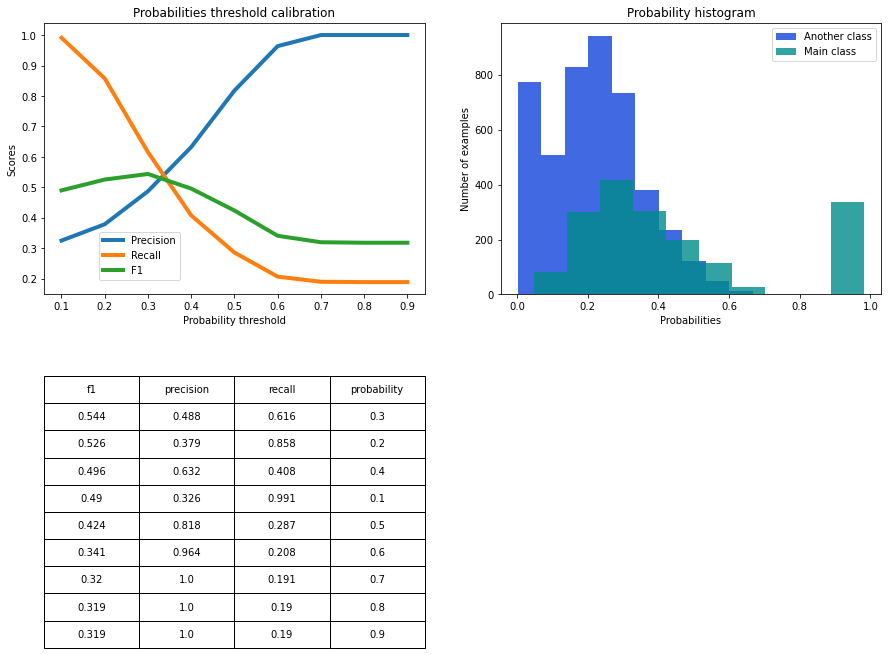

In [35]:
show_proba_calibration_plots(predict['lr_rf_lgm_mean'], y_train)

In [36]:
pred = predict['lr_rf_lgm_mean']>0.33
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4592
           1       0.54      0.55      0.54      1783

    accuracy                           0.74      6375
   macro avg       0.68      0.68      0.68      6375
weighted avg       0.74      0.74      0.74      6375



In [37]:
res = []
for i in np.arange(0.23,0.4,0.0001):
    pred = predict['lr_rf_lgm_mean']>i
    p=precision_score(y_train, pred)
    r = recall_score(y_train, pred)
    f = f1_score(y_train, pred)
    if all ([p>=0.52,f>=0.53,r>=0.52]):
        res.append((f,p,r,i))
res.sort(key = lambda x: x[0],reverse=True) 
res[:5]

[(0.5451621549182526,
  0.5220739219712526,
  0.5703869882220975,
  0.31939999999999014),
 (0.5447721179624666,
  0.5218284540318439,
  0.569826135726304,
  0.3194999999999901),
 (0.5447721179624666,
  0.5218284540318439,
  0.569826135726304,
  0.3195999999999901),
 (0.5445783132530121,
  0.5210040983606558,
  0.5703869882220975,
  0.31919999999999016),
 (0.5445783132530121,
  0.5210040983606558,
  0.5703869882220975,
  0.31929999999999015)]

Для прогшнозирования используем ансабль lr_rf_lgm_mean, порог 0.31939999